In [ ]:
Dentro de los asteroides también se encontró hierro, parece que los principales indicadores
de la cantidad de hierro son las piedras violetas y el tamaño de los mismos.

Con los datos recolectados R4 tratar de predecir la cantidad de hierro que tendrá un asteroide.

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot  as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [3]:
df = pd.read_csv('R4.csv')

In [4]:
df.describe()

,violet_stone_count,asteroid_size_km3,iron_kg
count,100.000000,100.000000,100.000000
mean,71.690000,0.654088,60.335629
std,44.399403,0.247960,31.515357
min,1.000000,0.114662,6.995585
25%,31.500000,0.497146,35.211681
50%,70.000000,0.664570,56.636521
75%,109.000000,0.784425,81.248217
max,149.000000,1.279256,139.324038


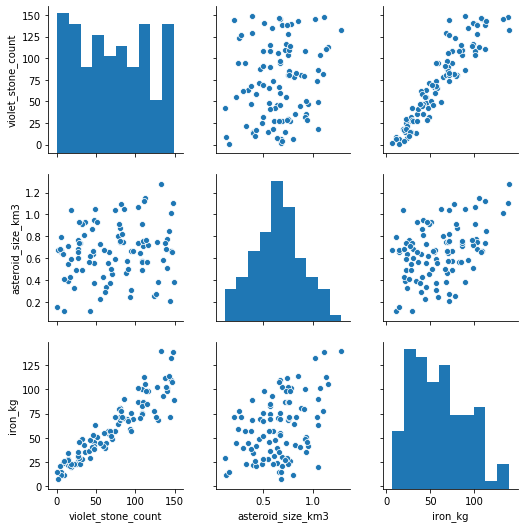

In [5]:
sns.pairplot(df)

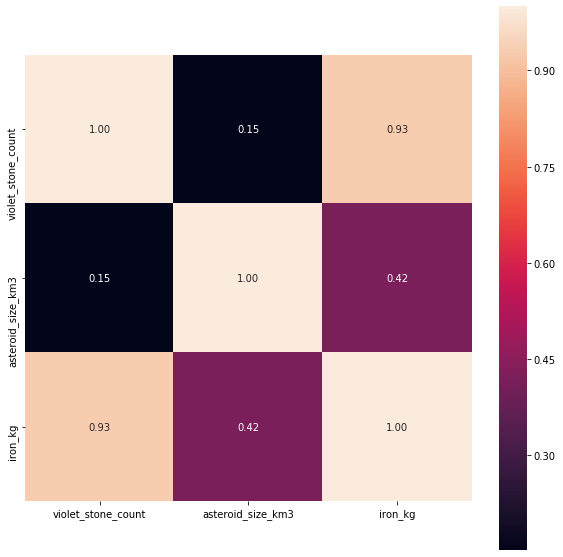

In [4]:
# Matriz de correlaciones como heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), square=True, annot=True, fmt='.2f')
plt.show()

In [9]:
df.columns

Index(['violet_stone_count', 'asteroid_size_km3', 'iron_kg'], dtype='object')

In [ ]:
# SHOULD CHECK LINEAR REGRESSION Assumptions !!! See R3 analysis !!
https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/

Assumptions
I) Linearity
II) Normality of the Error Terms
III) No Multicollinearity among Predictors
IV) No Autocorrelation of the Error Terms
V) Homoscedasticity

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


//anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


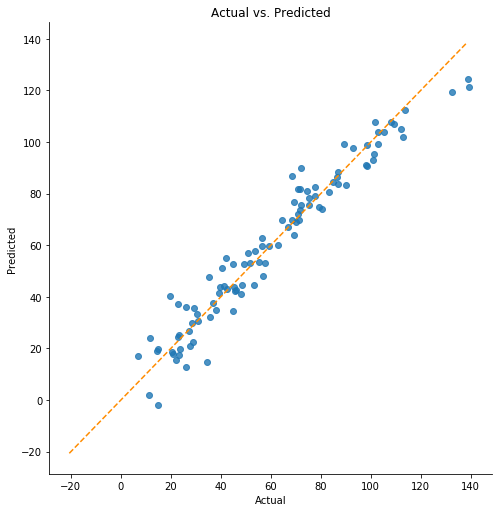

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.40577027588201314
Residuals are normally distributed


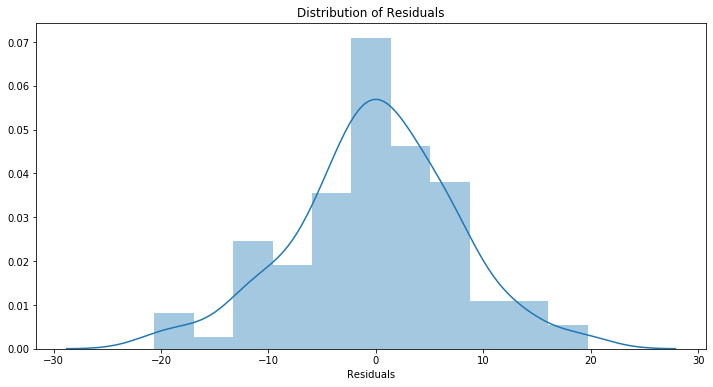


Assumption satisfied
Assumption 3: Little to no multicollinearity among predictors


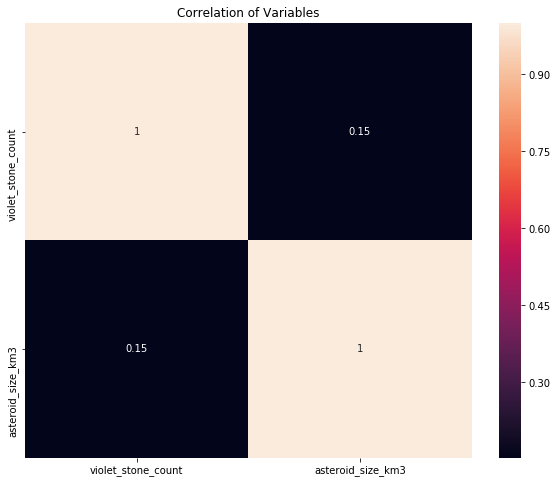

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
X1: 3.1292249100870957
X2: 3.1292249100870957

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.7614881422822841
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


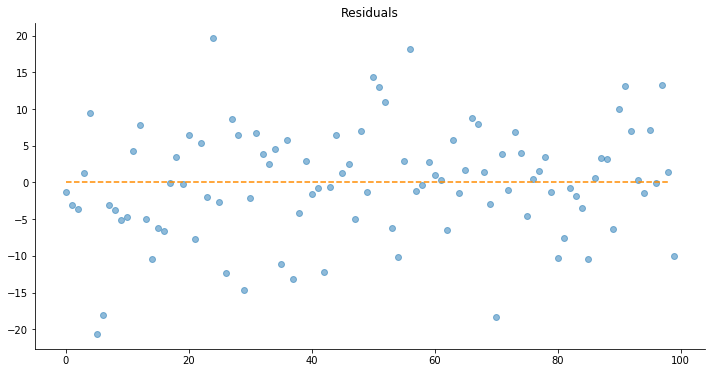

- There don’t appear to be any obvious problems with that.


In [50]:
## Linear Regression Assumptions 

def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

x = df[['violet_stone_count', 'asteroid_size_km3']]
y = df.iron_kg
regr = LinearRegression().fit(x, y)



## I) Linearity

def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

linear_assumption(regr, x, y)

#We can see a relatively even spread around the diagonal line.



## II) Normality of the Error Terms

def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    # ACA PODRIA USAR OTROS TEST TAMBIEN COMO POR EJEMPLO D’Agostino’s K^2 Test o Shapiro Test.
    # AUNQUE SEGUN ESTO "https://stackoverflow.com/questions/7781798/seeing-if-data-is-normally-distributed-in-r/7788452#7788452"
    # AL NO RECHAZAR HO, NO INDICA NECESARIAMENTE NORMALIDAD EN LA DISTRIB DE LOS DATOS, POR ENDE DEBERIA
    # BUSCAR UN TEST DONDE H1 SEA LA HIPOTESIS DE QUE LA DISTRIB DE LOS DATOS SON NORMALES 
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

normal_errors_assumption(regr, x, y)



## III) No Multicollinearity among Predictors

def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features.to_numpy(), i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

linear_feature_names = ['X'+str(feature+1) for feature in range(x.shape[1])]
multicollinearity_assumption(regr, x, y, linear_feature_names)

## IV) No Autocorrelation of the Error Terms 

def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

autocorrelation_assumption(regr, x, y)



## V) Homoscedasticity  

def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

homoscedasticity_assumption(regr, x, y)
print("- There don’t appear to be any obvious problems with that.")

## Fit Model 

In [15]:
def print_model_statistics(regr, y_test, y_pred):

    # The coefficients
    print('Coefficients: ', regr.coef_)

    # The intercept_ 
    print('Intercept (Y axis when X = 0): ', regr.intercept_)

    # The mean squared error
    print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

    # The coefficient of determination: 1 is perfect prediction
    r2 = r2_score(y_test, y_pred)
    print('Coefficient of determination: %.2f' % r2)
    
    # Adjusted r2
    n = X_test.shape[0]
    p = X_test.shape[1]
    adjusted_r2 = 1 - (1-r2) * (n-1)/(n-p-1)
    print('Adjusted r2: %.2f' % adjusted_r2)
    

In [45]:
X = df[['violet_stone_count', 'asteroid_size_km3']]
y = df.iron_kg

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [78]:
regr = LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

print_model_statistics(regr, y_test, y_pred)

Coefficients:  [ 0.60859656 38.94730251]
Intercept (Y axis when X = 0):  -9.298771586994256
Mean squared error: 80.97
Coefficient of determination: 0.94
Adjusted r2: 0.93


In [109]:
print("- Intercept (Y axis when X = 0) is negative, makes non sense this.")

- Intercept (Y axis when X = 0) is negative, makes non sense this.


## MinMaxScaler 

In [51]:
X = df[['violet_stone_count', 'asteroid_size_km3']]
y = df.iron_kg

seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

In [52]:
regr = LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

print_model_statistics(regr, y_test, y_pred)
print()
print("- Intercept (Y axis when X = 0) is negative, makes non sense this.")

Coefficients:  [93.21246234 42.46796626]
Intercept (Y axis when X = 0):  -4.2663142405166
Mean squared error: 50.20
Coefficient of determination: 0.95
Adjusted r2: 0.95

- Intercept (Y axis when X = 0) is negative, makes non sense this.


## StandardScaler 

In [53]:
X = df[['violet_stone_count', 'asteroid_size_km3']]
y = df.iron_kg

seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
regr = LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

print_model_statistics(regr, y_test, y_pred)

Coefficients:  [28.14611081  8.21807242]
Intercept (Y axis when X = 0):  60.636842941803096
Mean squared error: 52.13
Coefficient of determination: 0.95
Adjusted r2: 0.94


In [108]:
#example of use
violet_stone_count = 123
asteroid_size_km3 = 0.257110
scaled_data = scaler.transform([[violet_stone_count, asteroid_size_km3]])
print(regr.predict(scaled_data))

[75.57234628]


## feature engineering

In [41]:
df_ = df.copy()
df_["violet_stone_count_x_size_km3"] = df.asteroid_size_km3 * df.violet_stone_count

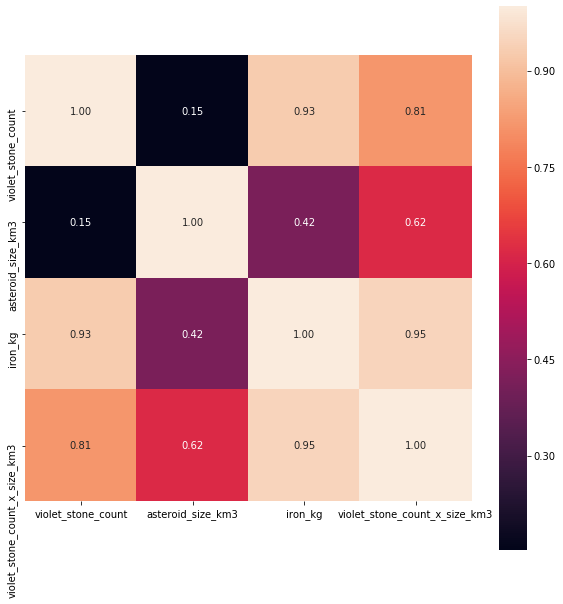


- We can observe a high correlation between the new feature and violet_stone_count and asteroid_size_km3


In [42]:
# Matriz de correlaciones como heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df_.corr(), square=True, annot=True, fmt='.2f')
plt.show()
print()
print("- We can observe a high correlation between the new feature and violet_stone_count and asteroid_size_km3")

In [55]:
X = df_[['violet_stone_count', 'asteroid_size_km3', 'violet_stone_count_x_size_km3']]
y = df_.iron_kg

seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [56]:
regr = LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

print_model_statistics(regr, y_test, y_pred)
print()
print("- Coefficients has a negative component, this is nonsense.")

Coefficients:  [13.616222   -0.92760056 18.92844411]
Intercept (Y axis when X = 0):  61.22614839299214
Mean squared error: 36.35
Coefficient of determination: 0.97
Adjusted r2: 0.96

- Coefficients has a negative component, this is nonsense.


## final model ! 

In [66]:
#
# - We'll remove asteroid_size_km3 and maintain violet_stone_count_x_size_km3
#

X = df_[['violet_stone_count', 'violet_stone_count_x_size_km3']]
y = df_.iron_kg

seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

#scaler = preprocessing.StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [67]:
regr = LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

print_model_statistics(regr, y_test, y_pred)

Coefficients:  [0.33396504 0.47693154]
Intercept (Y axis when X = 0):  12.980300521550568
Mean squared error: 36.33
Coefficient of determination: 0.97
Adjusted r2: 0.96


In [63]:
meh = scaler.transform([[1, 0]])
meh

array([[-1.71102381, -1.32592942]])

In [71]:
regr.predict([[4, 0]])

array([14.31616068])

Assumption 3: Little to no multicollinearity among predictors


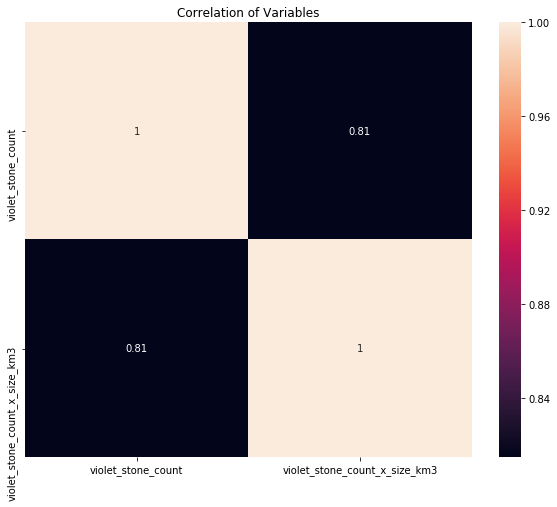

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
X1: 7.80111983347286
X2: 7.80111983347286

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied

- Possible multicollinearities were removed


In [48]:
linear_feature_names = ['X'+str(feature+1) for feature in range(X.shape[1])]
multicollinearity_assumption(regr, X, y, linear_feature_names)
print()
print("- Possible multicollinearities were removed")

## Residual PDF (targets - predictions)

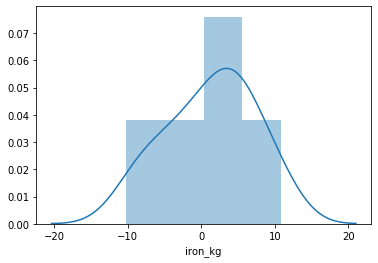

In [49]:
sns.distplot(y_test - y_pred)

As we can see from the graph some observations for which (targets-precition) is lower than the mean. These means that a higher amount of iron is predicted than is observe. On the other side of the graph we can see that the predictions doesn't underestimate the targets.

In [ ]:
#difference between r2_score and explained_variance_score?
https://stackoverflow.com/questions/24378176/python-sci-kit-learn-metrics-difference-between-r2-score-and-explained-varian

In [ ]:
#adjusted r squared
https://datascience.stackexchange.com/questions/14693/what-is-the-difference-of-r-squared-and-adjusted-r-squared
https://www.investopedia.com/ask/answers/012615/whats-difference-between-rsquared-and-adjusted-rsquared.asp

In [ ]:
#Difference between preprocessing train and test set before and after splitting
https://stats.stackexchange.com/questions/267012/difference-between-preprocessing-train-and-test-set-before-and-after-splitting

In [ ]:
#interaction effects and interaction plots!
https://statisticsbyjim.com/regression/interaction-effects/